# Part 5 - Additional Geometry Guide

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1">Preparation</a></span></li><li><span><a href="#Check-geometry-engine" data-toc-modified-id="Check-geometry-engine-2">Check geometry engine</a></span></li><li><span><a href="#Object-Model-Diagram-(OMD)-of-the-geometry-module" data-toc-modified-id="Object-Model-Diagram-(OMD)-of-the-geometry-module-3">Object Model Diagram (OMD) of the geometry module</a></span></li><li><span><a href="#Extracting-geometries-from-existing-feature-layers" data-toc-modified-id="Extracting-geometries-from-existing-feature-layers-4">Extracting geometries from existing feature layers</a></span><ul class="toc-item"><li><span><a href="#Get-geometries-from-a-web-feature-layer" data-toc-modified-id="Get-geometries-from-a-web-feature-layer-4.1">Get geometries from a web feature layer</a></span></li><li><span><a href="#Get-geometries-from-a-local-layer" data-toc-modified-id="Get-geometries-from-a-local-layer-4.2">Get geometries from a local layer</a></span></li></ul></li><li><span><a href="#Construct-higher-level-objects-from-geometry-objects" data-toc-modified-id="Construct-higher-level-objects-from-geometry-objects-5">Construct higher level objects from geometry objects</a></span><ul class="toc-item"><li><span><a href="#Create-a-Feature-or-FeatureSet-object" data-toc-modified-id="Create-a-Feature-or-FeatureSet-object-5.1">Create a Feature or FeatureSet object</a></span></li><li><span><a href="#Create-an-SeDF-object-with-geometries" data-toc-modified-id="Create-an-SeDF-object-with-geometries-5.2">Create an SeDF object with geometries</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-6">Conclusions</a></span></li></ul></div>

## Preparation

To start with, import necessary libraries and get connected to the ArcGIS Online organization:

In [1]:
import pandas as pd
from arcgis.geometry import Geometry, Point, project
from arcgis.features import Feature, FeatureSet, FeatureLayer, FeatureCollection, GeoAccessor, GeoSeriesAccessor
from arcgis.gis import GIS

# Organization Login
gis = GIS('http://www.arcgis.com', 'arcgis_python', 'P@ssword123', verify_cert=False)

## Check geometry engine

Based on how the ArcGIS for API is installed on the client-side set-up, there could be three local environments for geometry module:
 - with arcpy geometry engine
 - with shapely geometry engine
 - without geometry engines
 
The function `show_geometry` is defined below to check what environment is set up on the client-side, and display the geometry object accordingly:

In [3]:
def show_geometry(geom_obj):
    try:
        import arcpy
        print("arcpy is supported")
        display(geom_obj.as_arcpy)
    except:
        print("arcpy is not supported")
        try:
            import shapely
            print("shapely is supported")
            display(geom_obj.as_shapely)
        except:
            print("shapely is not supported")
            print(geom_obj.JSON)

For example, with a `Point` object declared below, the `show_geometry` function not only prints that `shapely` geometry engine is set up on local environment, but also draws the graphic representation of the Point object.

arcpy is not supported
shapely is supported


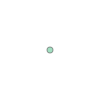

In [4]:
pt = Point({'x': 13.2597627, 'y': 52.4898306, 'spatialReference': {'wkid': 4326}})
show_geometry(pt)

Besides using the customized function to detect the geometry engine installed, the built-in function `_check_geometry_engine` returns a tuple of boolean values representing if `arcpy` and/or `shapely` geometry engine is installed.

In [7]:
pt._check_geometry_engine()

(False, True)

In [5]:
pt._HASARCPY

False

In [6]:
pt._HASSHAPELY

True

## Object Model Diagram (OMD) of the geometry module

The picture below illustrates how the geometry module is organized (which showcase only the important objects, sub-modules, and properties via the OMD):


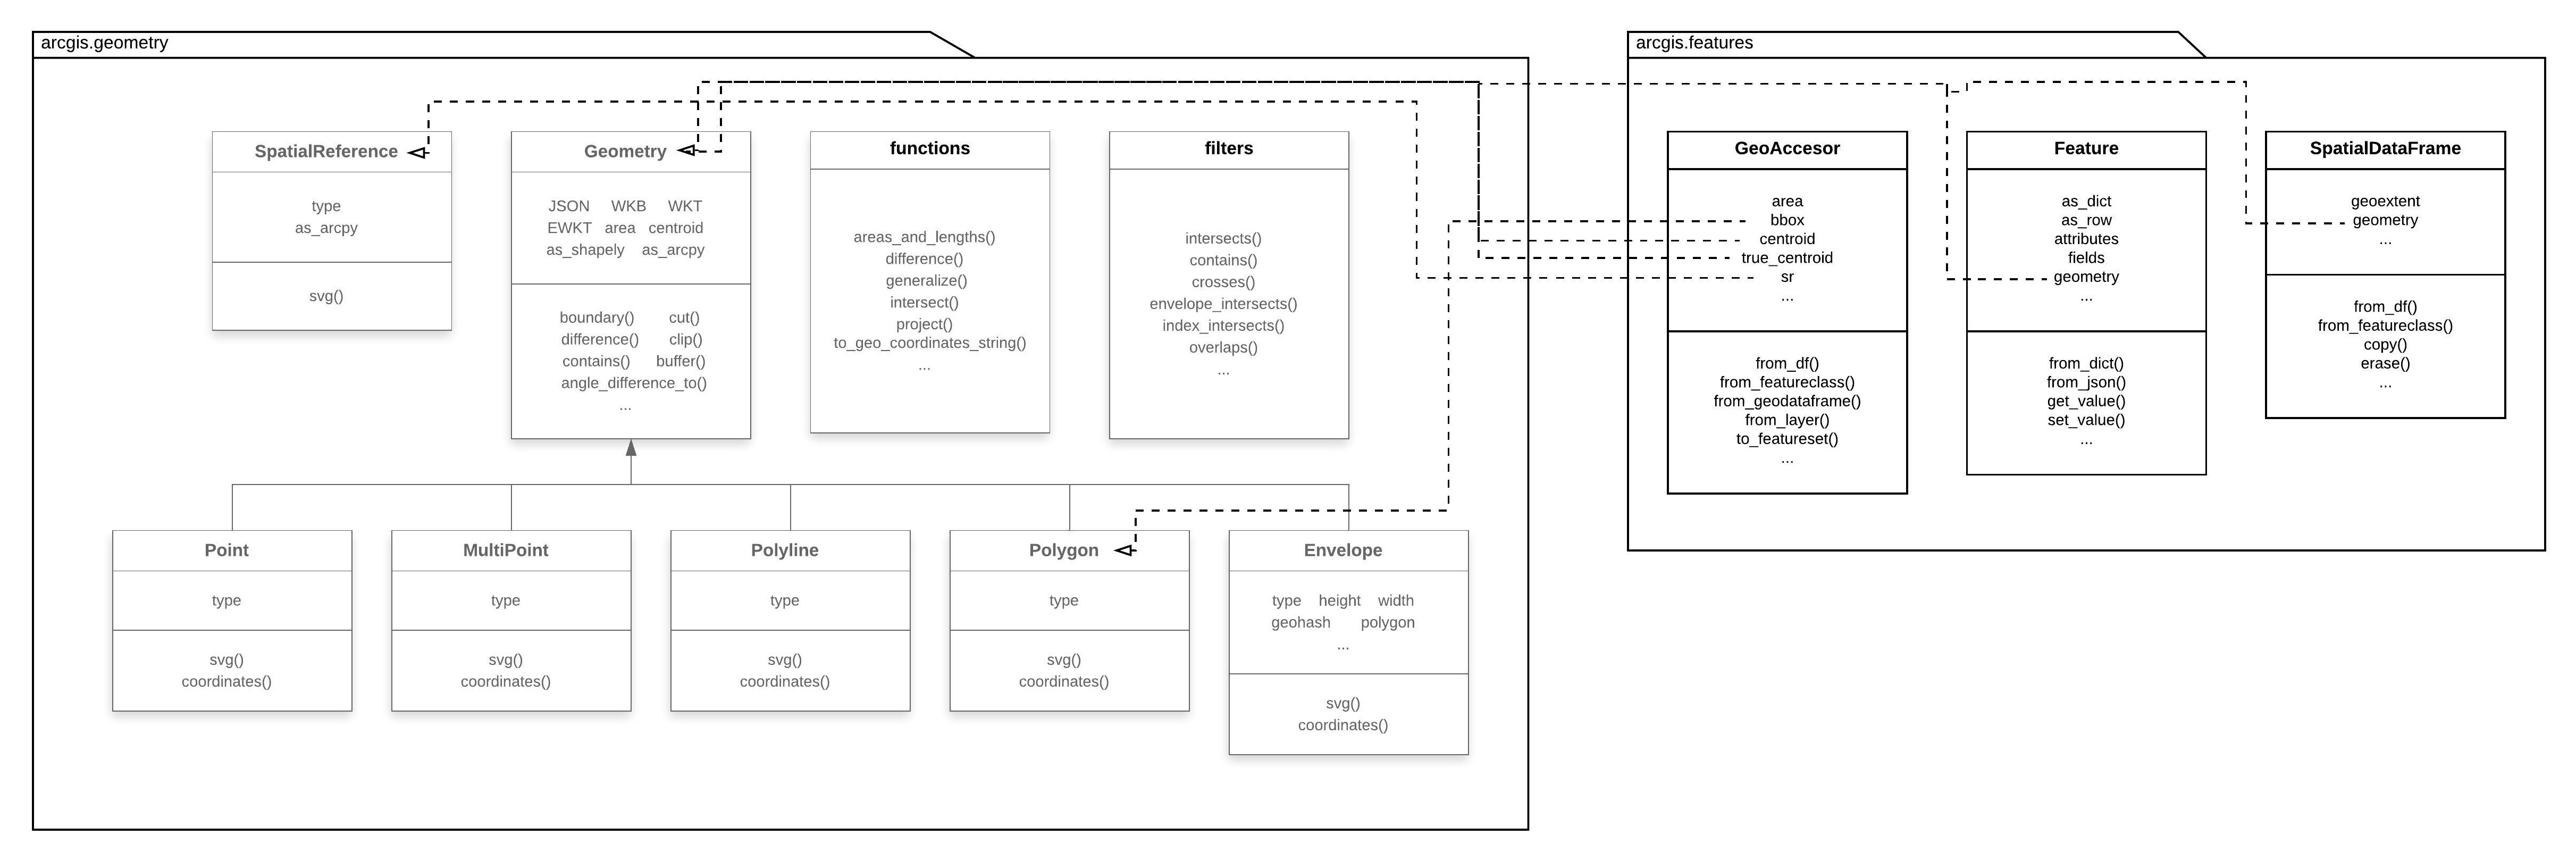

In [139]:
# display the OMD of the geometry module

Refer to the rest of this guide page to learn how to access your geometries, or to create new objects out of them.

## Extracting geometries from existing feature layers

Besides creating geometries from scratch, we can also access geometries from existing feature classes, and feature layers - either remotely on the web, or stored locally. Let's first explore how to get geometries from a web feature layer.

### Get geometries from a web feature layer

Next, we will be looking at a path where geometry objects are extracted from Spatially Enabled DataFrame (SeDF) which is obtained from `FeatureLayer` (in short, the path can be represented as `FeatureLayer` -> `SeDF` -> `geometry` objects).

In [10]:
dc_fl = FeatureLayer('https://maps2.dcgis.dc.gov/dcgis/rest/services/DCGIS_DATA/Administrative_Other_Boundaries_WebMercator/MapServer/10')
dc_df = GeoAccessor.from_layer(dc_fl)
display(dc_df.head())

,OBJECTID,CITY_NAME,STATE_CITY,CAPITAL,WEB_URL,AREAKM,AREAMILES,Shape_Length,Shape_Area,SHAPE
0,1,Washington,1150000,Y,http://www.dc.gov,177.47,68.52,67608.276922,1.774562e+08,"{""rings"": [[[-8584936.334474642, 4712272.26069..."


Before moving forward, we can save the `SeDF` into a local `FeatureClass` object (in the format of shapefile), which can be utilized in the next section.

In [136]:
dc_shp_path = dc_df.spatial.to_featureclass("./dc_feature_class")
dc_shp_path

./dc_feature_class.shp


In [11]:
type(dc_df.spatial)

arcgis.features.geo._accessor.GeoAccessor

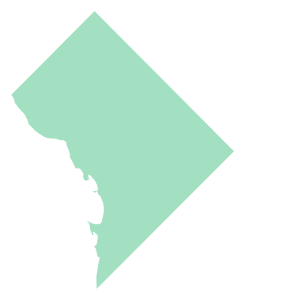

In [12]:
display(dc_df.spatial)

<class 'arcgis.geometry._types.Polygon'>


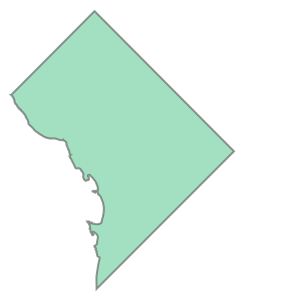

In [13]:
print(type(dc_df.iloc[0].SHAPE))
display(dc_df.iloc[0].SHAPE)

<class 'arcgis.geometry._types.Polygon'>


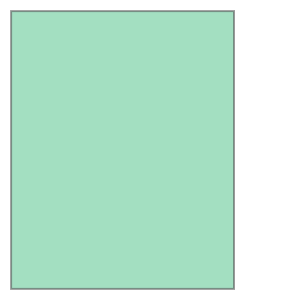

In [14]:
print(type(dc_df.spatial.bbox))
display(dc_df.spatial.bbox)


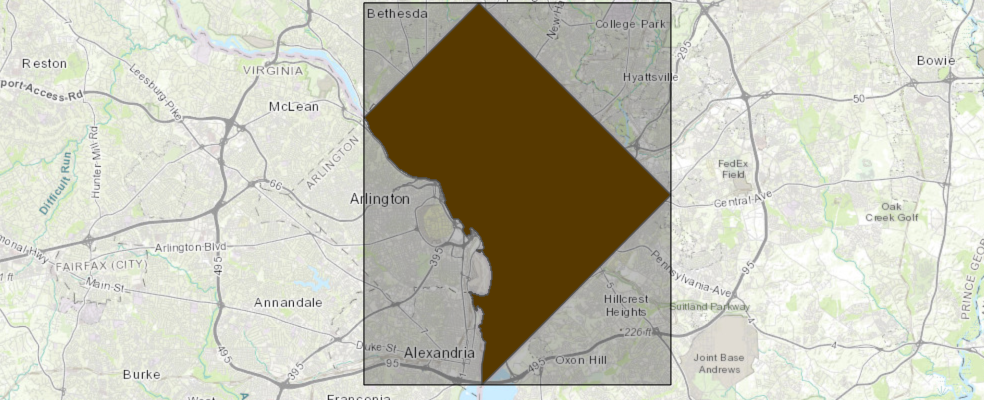

In [138]:
dc_map = gis.map('Washington DC')
dc_map

In [16]:
dc_map.draw(dc_df.iloc[0].SHAPE, 
            symbol={
                      "type": "esriSFS",
                      "style": "esriSFSSolid",
                      "color": [115,76,0,255],
                        "outline": {
                         "type": "esriSLS",
                         "style": "esriSLSSolid",
                         "color": [110,110,110,255],
                         "width": 1}
                    })
dc_map.draw(dc_df.spatial.bbox)

In [21]:
dc_extent = dc_df.spatial.full_extent
dc_coords = project([[dc_extent[0], dc_extent[1]], [dc_extent[2], dc_extent[3]]], in_sr=3857, out_sr=4326)
print(dc_coords)
dc_bounds = f"({dc_coords[0]['coordinates'][1]},{dc_coords[0]['coordinates'][0]},{dc_coords[1]['coordinates'][1]},{dc_coords[1]['coordinates'][0]})"
print(dc_bounds)

[{'type': 'Point', 'coordinates': [-77.1197952245159, 38.79164435125454]}, {'type': 'Point', 'coordinates': [-76.90914996169623, 38.995968036509325]}]
(38.79164435125454,-77.1197952245159,38.995968036509325,-76.90914996169623)


Besides the first approach (`FeatureLayer` -> `SeDF` -> `geometry`), geometries can also be extracted from `FeatureSet` or `Feature` objects (in short, this path can be represented as `FeatureLayer` -> `FeatureSet` -> `Feature` -> `geometry` objects).

In [22]:
# polling places
pp_fl = FeatureLayer('https://maps2.dcgis.dc.gov/dcgis/rest/services/DCGIS_DATA/Administrative_Other_Boundaries_WebMercator/MapServer/20')
pp_df = GeoAccessor.from_layer(pp_fl)
display(pp_df.head())

,OBJECTID,PRECINCT_N,FACILITY_D,ACCESSIBLE,GIS_ID,WEB_URL,NAME,ADDRESS,ADDRESS_ID,WARD,X,Y,PORTION,ZIPCODE,SHAPE
0,90,140.0,Gymnasium,Y,plp_ 1,https://www.dcboe.org/Voters/Where-to-Vote/Pol...,Anacostia Sr. High School,1601 16TH STREET SE,155922.0,Ward 8,401468.56,133584.50,Null,20020.0,"{""x"": -8569716.959241048, ""y"": 4703079.2765319..."
1,91,60.0,Church Hall,Y,plp_ 3,https://www.dcboe.org/Voters/Where-to-Vote/Pol...,St. John United Baptist Church,6343 13TH STREET NW,253260.0,Ward 4,397459.85,144369.76,Null,20011.0,"{""x"": -8574863.672780711, ""y"": 4716979.8915497..."
2,92,52.0,Roth Gymnasium,Y,plp_ 4,https://www.dcboe.org/Voters/Where-to-Vote/Pol...,St. John's College High School,2607 MILITARY ROAD NW,259840.0,Ward 4,395215.50,143835.60,Null,20015.0,"{""x"": -8577746.177870367, ""y"": 4716289.6382021..."
3,93,7.0,Recreation Room,Y,plp_ 6,https://www.dcboe.org/Voters/Where-to-Vote/Pol...,Hardy Recreation Center,4500 Q STREET NW,284929.0,Ward 3,392629.43,138009.47,Null,20007.0,"{""x"": -8581060.853281725, ""y"": 4708776.0392236..."
4,94,73.0,Library (Lower Level),Y,plp_ 7,https://www.dcboe.org/Voters/Where-to-Vote/Pol...,Mary McLeod Bethune Day Academy PCS,1404 JACKSON STREET NE,294522.0,Ward 5,401138.94,140191.85,Null,20017.0,"{""x"": -8570138.568114452, ""y"": 4711593.2341477..."


<class 'arcgis.features.geo._accessor.GeoAccessor'>


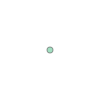

In [23]:
print(type(pp_df.spatial))
display(pp_df.iloc[0].SHAPE)

In [31]:
pp_fset = pp_fl.query()
pp_fset

<FeatureSet> 143 features

{"geometry": {"x": -8574151.194696952, "y": 4704478.692972534}, "attributes": {"OBJECTID": 73, "PRECINCT_N": 142.0, "FACILITY_D": "Gymnasium", "ACCESSIBLE": "Y", "GIS_ID": "plp_ 101", "WEB_URL": "https://www.dcboe.org/Voters/Where-to-Vote/Polling-Places", "NAME": "Jefferson Middle School", "ADDRESS": "801 7TH STREET SW", "ADDRESS_ID": 276812.0, "WARD": "Ward 6", "X": 398012.08, "Y": 134671.03, "PORTION": "Null", "ZIPCODE": 20024.0}}


{'x': -8574151.194696952, 'y': 4704478.692972534}

arcpy is not supported
shapely is supported


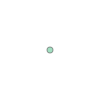

In [42]:
for pp_feature in pp_fset:
    if pp_feature.attributes["FACILITY_D"]=="Gymnasium" and pp_feature.attributes["PRECINCT_N"]>140:
        print(pp_feature)
        display(pp_feature.geometry)
        show_geometry(Geometry(pp_feature.geometry))

In [43]:
pp_coords = project([[-8574151.194696952, 4704478.692972534]], in_sr=3857, out_sr=4326)
print(pp_coords)
pp_bounds = f"({pp_coords[0]['coordinates'][1]},{dc_coords[0]['coordinates'][0]})"
print(pp_bounds)

[{'type': 'Point', 'coordinates': [-77.02291066547926, 38.87987093229287]}]
(38.87987093229287,-77.1197952245159)


arcpy is not supported
shapely is supported


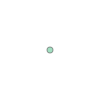

In [44]:
show_geometry(Geometry({'x': 38.87987093229287, 'y': -77.1197952245159}))

### Get geometries from a local layer

Previously, we have seen how geometries can be extracted from existing web feature layer, let's now take a look at how to read a local layer into a `SeDF` and get geometries from it. The local `FeatureClass` object which we had saved into a shapefile is to be used here:

In [122]:
dc_df_from_fc = GeoAccessor.from_featureclass(dc_shp_path)
dc_df_from_fc

,index,objectid,city_name,state_city,capital,web_url,areakm,areamiles,shape_leng,shape_area,SHAPE,OBJECTID
0,0,1,Washington,1150000,Y,http://www.dc.gov,177.47,68.52,67608.276922,1.774562e+08,"{""rings"": [[[-8584936.334474642, 4712272.26069...",0


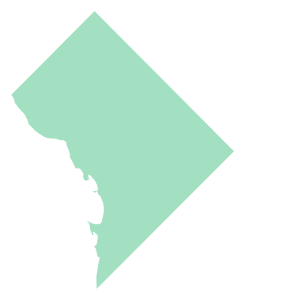

In [123]:
dc_df_from_fc.spatial

In [135]:
dc_df_from_fc["SHAPE"]

0    {"rings": [[[-8584936.334474642, 4712272.26069...
Name: SHAPE, dtype: geometry

## Construct higher level objects from geometry objects

Now we have learnt how to extract geometries from `FeatureLayer`, `FeatureSet`, `Feature` objects, and local feature layer, let's turn the workflow upside down, and focus at composing `Feature`, `FeatureSet`, and `SeDF` objects from geometry objects:


### Create a Feature or FeatureSet object

With geometry objects (point or line or polygon) created, how do we create a `Feature`, and `FeatureSet` objects out of them? Let's first look at an example of two Point geometries created from scratch:

In [45]:
pt_1 = Point({'x': -101.376, 'y': 31.119})
fire_1 = Feature(geometry=pt_1, attributes={"id": "EONET_4959",
                                            "title": "Ferguson Fire",
                                            "description": "",
                                            "link": "https://eonet.sci.gsfc.nasa.gov/api/v2.1/events/EONET_4959",
                                            "categories": {
                                                "id": 8,
                                                "title": "Wildfires"
                                            }})
fire_1

{"geometry": {"x": -101.376, "y": 31.119}, "attributes": {"id": "EONET_4959", "title": "Ferguson Fire", "description": "", "link": "https://eonet.sci.gsfc.nasa.gov/api/v2.1/events/EONET_4959", "categories": {"id": 8, "title": "Wildfires"}}}

In [46]:
pt_2 = Point({'x': -101.91, 'y': 30.859999999999999})
fire_2 = Feature(geometry=pt_2, attributes={"id": "EONET_4958",
                                            "title": "Smith Canyon Fire",
                                            "description": "",
                                            "link": "https://eonet.sci.gsfc.nasa.gov/api/v2.1/events/EONET_4958",
                                            "categories": {
                                                "id": 8,
                                                "title": "Wildfires"
                                            }})
fire_2

{"geometry": {"x": -101.91, "y": 30.86}, "attributes": {"id": "EONET_4958", "title": "Smith Canyon Fire", "description": "", "link": "https://eonet.sci.gsfc.nasa.gov/api/v2.1/events/EONET_4958", "categories": {"id": 8, "title": "Wildfires"}}}

In [47]:
fires_fset = FeatureSet(features = [fire_1, fire_2], 
                        geometry_type="Point", 
                        spatial_reference={'latestWkid': 4326, 'wkid': 102100})
fires_fset

<FeatureSet> 2 features

In [54]:
fires_fset.sdf

,id,title,description,link,categories,OBJECTID,SHAPE
0,EONET_4959,Ferguson Fire,,https://eonet.sci.gsfc.nasa.gov/api/v2.1/event...,"{'id': 8, 'title': 'Wildfires'}",1,"{""type"": ""Point"", ""coordinates"": [-101.376, 31..."
1,EONET_4958,Smith Canyon Fire,,https://eonet.sci.gsfc.nasa.gov/api/v2.1/event...,"{'id': 8, 'title': 'Wildfires'}",2,"{""type"": ""Point"", ""coordinates"": [-101.91, 30...."


In [63]:
fires_fc = FeatureCollection.from_featureset(fset=fires_fset)
fires_fc

<FeatureCollection>

### Create an SeDF object with geometries

Besides `Feature`, `FeatureSet`, and `FeatureCollection`, `SeDF` objects can also be created with geometry objects.

In [101]:
dc_recycle_geom1_dict = {"x":-77.1188753,"y":38.8614258,"spatialReference":{"wkid":4326}}
dc_recycle_geom2_dict = {"x":-77.08481,"y":38.8478148,"spatialReference":{"wkid":4326}}

arcpy is not supported
shapely is supported


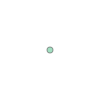

In [102]:
dc_recycle_geom1 = Geometry(dc_recycle_geom1_dict)
show_geometry(dc_recycle_geom1)

arcpy is not supported
shapely is supported


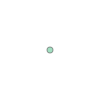

In [103]:
dc_recycle_geom2 = Geometry(dc_recycle_geom2_dict)
show_geometry(dc_recycle_geom2)

In [106]:
dc_recycle_dict = {"osm_id":{"0":"2607287308","1":"3752101908"},
                   "amenity":{"0":"recycling","1":"recycling"},
                   "source":{"0":"site visit","1":"GPSO"},
                   "recycling_type":{"0":"container","1":"container"}
                   }
dc_recycle_df = pd.DataFrame.from_dict(dc_recycle_dict)
dc_recycle_df.head()

,osm_id,amenity,source,recycling_type
0,2607287308,recycling,site visit,container
1,3752101908,recycling,GPSO,container


In [107]:
dc_recycle_df["X"] = [dc_recycle_geom1.x, dc_recycle_geom2.x]
dc_recycle_df["Y"] = [dc_recycle_geom1.y, dc_recycle_geom2.y]
dc_recycle_df.head()

,osm_id,amenity,source,recycling_type,X,Y
0,2607287308,recycling,site visit,container,-77.118875,38.861426
1,3752101908,recycling,GPSO,container,-77.084810,38.847815


In [108]:
dc_recycle_sedf = GeoAccessor.from_xy(dc_recycle_df, x_column="X", y_column="Y", sr=4326)
dc_recycle_sedf.head()

,osm_id,amenity,source,recycling_type,X,Y,SHAPE
0,2607287308,recycling,site visit,container,-77.118875,38.861426,"{""spatialReference"": {""wkid"": 4326}, ""x"": -77...."
1,3752101908,recycling,GPSO,container,-77.084810,38.847815,"{""spatialReference"": {""wkid"": 4326}, ""x"": -77...."


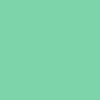

In [109]:
dc_recycle_sedf.spatial

## Conclusions

This Part 5 of the Geometry Guide explores how geometries can be extracted from existing web layers or local feature classes, and also provides introduction to how Feature, FeatureSet, FeatureCollection and SeDF objects can be constructed from geometries.